In [178]:
# !pip install pandas 
# !pip install datasets tqdm scikit-learn evaluate
# !pip install scikit-learn
# # !pip install accelerate 
### for bash  python -m pip install -U "accelerate>=0.26.0"
#!pip install -U "transformers==4.54.1" 

#!{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121.
# python -m pip install --upgrade pip setuptools wheel
# python -m pip install transformers datasets tqdm pandas scikit-learn accelerate


In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import transformers, accelerate
from transformers import AutoTokenizer, AutoConfig,AutoModelForSequenceClassification, Trainer, TrainingArguments , EarlyStoppingCallback
from datasets import Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from nltk.tokenize import TweetTokenizer
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import sys
import subprocess
import tqdm as notebook_tqdm

c:\Users\HRMic\OneDrive - ADvTECH Ltd\Documents\VS code\Python_VS\TWITTER\Research\gpuEnv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Fine-tune**

In [ ]:
config = AutoConfig.from_pretrained(
    "m-newhauser/distilbert-political-tweets",
    num_labels=2
)
config.dropout =  0.2
config.attention_dropout =  0.2

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "m-newhauser/distilbert-political-tweets",
    config=config,
    use_safetensors=True,
torch_dtype=torch.float32,
).to(torch.float32)

**Reinitialize the top 2 layers**

In [ ]:
# Reinitialize the top layers
reinit_layers = 2 
# for the last `reinit_layers` transformer layers, reinitialize weights
for layer in model.distilbert.transformer.layer[-reinit_layers:]:
    for module in layer.modules():
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

# reinitialize the classifier head
model.classifier = nn.Linear(model.config.hidden_size, model.config.num_labels)
nn.init.normal_(model.classifier.weight, mean=0.0, std=model.config.initializer_range)
nn.init.zeros_(model.classifier.bias)
print(f"Reinitialized top {reinit_layers} transformer layers and classifier.")


In [ ]:
# Increase dropout a touch on DistilBERT’s head
if hasattr(model.config, "seq_classif_dropout"):
    model.config.seq_classif_dropout = 0.15 # 15 =0.12  

# Rebuild the classifier with dropout 
model.classifier = nn.Sequential(
    nn.Dropout(0.15),# 15 =0.12  
    # nn.Linear(model.config.dim, model.config.num_labels)
    nn.Linear(model.config.hidden_size, model.config.num_labels)
)
for m in model.classifier.modules():
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=model.config.initializer_range)
        nn.init.zeros_(m.bias)
 # (Nadzmi, 2022; KGP Talkie, 2023; Khan, 2025)

<!-- **Fine-Tune Parameters** -->


In [ ]:
MODEL_NAME = "m-newhauser/distilbert-political-tweets" 
TEXT_COL = "text"     
LABEL_COL = "label"  
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 15   # (Nadzmi, 2022; KGP Talkie, 2023; Khan, 2025)

In [ ]:
# Load full dataset
df = pd.read_csv("For Fine/2020_LD_cleaned_tweets.csv")

# Shuffle and stratify by label
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df[LABEL_COL],
    random_state=42,
    shuffle=True
)

# Convert to Hugging Face datasets
ds = {
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True))
}

In [ ]:
# encode labels for model training
# gather labels from both splits
unique_labels = sorted(
    set(ds["train"][LABEL_COL]) | set(ds["validation"][LABEL_COL])
)
# create mapping dicts
label2id = {name: i for i, name in enumerate(unique_labels)}
id2label = {i: name for name, i in label2id.items()}
 # function to encode labels
def encode_label(example):
    example[LABEL_COL] = label2id[example[LABEL_COL]]
    return example

# apply encoding to both splits
ds["train"] = ds["train"].map(encode_label)
ds["validation"] = ds["validation"].map(encode_label)

num_labels = len(id2label)
print("Labels:", id2label)


Map: 100%|██████████| 1924/1924 [00:00<00:00, 56587.97 examples/s]

Labels: {0: 'Left', 1: 'Right'}


In [ ]:
# tokenizer for distilbert-political-tweets
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# set up tweet tokenizer
# - preserve case, to enable lowercasing 
# - reduce_len to limit repeated characters
tweet_tknzr = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=False)
hf_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# function to preprocess and tokenize tweets
def preprocess_and_tokenize(batch):
    tokenized_tweets = [" ".join(tweet_tknzr.tokenize(text)) for text in batch[TEXT_COL]]
    return tokenizer(
        tokenized_tweets,
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )

# for both splits, preprocess and tokenize
ds_tokenized = {}
for split in ["train", "validation"]:
    ds_tokenized[split] = ds[split].map(preprocess_and_tokenize, batched=True)
    ds_tokenized[split] = ds_tokenized[split].rename_column(LABEL_COL, "labels")
    ds_tokenized[split].set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map: 100%|██████████| 1924/1924 [00:00<00:00, 6877.45 examples/s]


In [ ]:
# used for when classes were imbalanced
use_class_weights = False
if use_class_weights:
    # compute weights from training distribution
    counts = np.bincount(np.array(ds_tokenized["train"]["labels"]), minlength=num_labels)
    weights = 1.0 / np.maximum(counts, 1)
    weights = weights / weights.sum() * num_labels
    class_weights = torch.tensor(weights, dtype=torch.float)
    print("Class weights:", class_weights)
else:
    class_weights = None

In [ ]:
# class WeightedTrainer, if using class weights
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Pop labels so they don't get fed to the model
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device) if class_weights is not None else None)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1)
)

        return (loss, outputs) if return_outputs else loss


In [ ]:
# function to compute evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="macro")
    rec = recall_score(labels, preds, average="macro")
    return {"accuracy": acc, "f1_macro": f1, "precision_macro": prec, "recall_macro": rec}

In [ ]:
# set training arguments
steps_per_epoch = max(1, len(ds_tokenized["train"]) // BATCH_SIZE)
eval_steps = max(1, steps_per_epoch // 2)
eval_steps = 100
training_args = TrainingArguments(
    learning_rate= 2e-5, 
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.1,               
    eval_strategy="epoch",            
    save_strategy="epoch",           
    logging_strategy="steps",
    logging_steps=eval_steps,
    eval_steps=eval_steps,
    save_steps=eval_steps,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    # warmup_ratio=0.09,                    
    report_to="none",
    label_smoothing_factor=0.07,
    lr_scheduler_type="linear",  
    gradient_accumulation_steps=2,

    dataloader_pin_memory=True,
    dataloader_num_workers=min(8, os.cpu_count() or 2),
    fp16=True,  
    gradient_checkpointing=True,        
)
 # (Sanh et al., 2019; Nadzmi, 2022; KGP Talkie, 2023; Khan, 2025)



In [ ]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=ds_tokenized["train"],
    eval_dataset=ds_tokenized["validation"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)
print("Trainer model device:", next(trainer.model.parameters()).device)
 # begin training
trainer.train()
metrics = trainer.evaluate()
print(metrics)

Trainer model device: cuda:0


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,No log,0.560498,0.773909,0.773796,0.774457,0.773909
2,No log,0.605048,0.781705,0.781580,0.782350,0.781705
3,0.244300,0.642656,0.787422,0.787405,0.787512,0.787422
4,0.244300,0.653987,0.779106,0.779101,0.779130,0.779106
5,0.244300,0.655042,0.782744,0.782744,0.782746,0.782744


{'eval_loss': 0.6426560282707214, 'eval_accuracy': 0.7874220374220374, 'eval_f1_macro': 0.7874054400299123, 'eval_precision_macro': 0.7875118223432831, 'eval_recall_macro': 0.7874220374220374, 'eval_runtime': 44.0235, 'eval_samples_per_second': 43.704, 'eval_steps_per_second': 0.454, 'epoch': 5.0}


In [ ]:
trainer.lr_scheduler.get_last_lr()

[0.0, 0.0]

In [ ]:
round = "./model22/OUTPUT_DIR"
# save model and tokenizer
trainer.save_model(round)             
tokenizer.save_pretrained(round)

('./model22/OUTPUT_DIR\\tokenizer_config.json',
 './model22/OUTPUT_DIR\\special_tokens_map.json',
 './model22/OUTPUT_DIR\\vocab.txt',
 './model22/OUTPUT_DIR\\added_tokens.json',
 './model22/OUTPUT_DIR\\tokenizer.json')

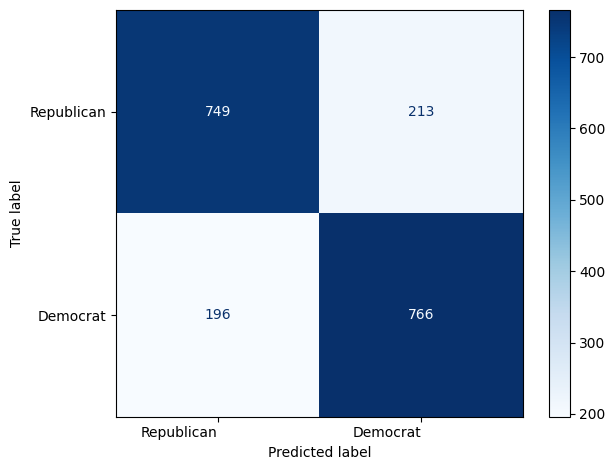

In [207]:
eval_split = ds_tokenized["validation"] 
pred_output = trainer.predict(eval_split)
y_true = pred_output.label_ids
y_pred = pred_output.predictions.argmax(axis=-1)
id2label = trainer.model.config.id2label
label_ids = sorted(id2label)   
label_list = [id2label[i] for i in label_ids]

cm = confusion_matrix(y_true, y_pred, labels=label_ids)
disp = ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(values_format="d", cmap="Blues")
plt.xticks(ha="right")
plt.tight_layout()
plt.show()

### **Polish**

In [2]:
MODEL_PATH = "model19/OUTPUT_DIR"
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH,
    use_safetensors=True,
    torch_dtype=torch.float32
).to(torch.float32)

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)


`torch_dtype` is deprecated! Use `dtype` instead!
Some weights of the model checkpoint at model19/OUTPUT_DIR were not used when initializing DistilBertForSequenceClassification: ['classifier.1.bias', 'classifier.1.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at model19/OUTPUT_DIR and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for

In [32]:
df = pd.read_csv("For Fine/2020_LD_cleaned_tweets.csv")

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    shuffle=True,
    random_state=43
)


In [33]:
ds = {
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True))
}


In [34]:
unique_labels = sorted(df["label"].unique())
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}
num_labels = len(unique_labels)

print(label2id)
print(id2label)

{'Left': 0, 'Right': 1}
{0: 'Left', 1: 'Right'}


In [35]:
def encode_label(example):
    example["label"] = label2id[example["label"]]
    return example

ds["train"] = ds["train"].map(encode_label)
ds["validation"] = ds["validation"].map(encode_label)

Map: 100%|██████████| 1924/1924 [00:00<00:00, 33177.41 examples/s]


In [36]:
tweet_tknzr = TweetTokenizer(
    preserve_case=False,
    reduce_len=True,
    strip_handles=False
)

def preprocess_and_tokenize(batch):
    tok = [" ".join(tweet_tknzr.tokenize(text)) for text in batch["text"]]
    return tokenizer(tok, padding="max_length", truncation=True, max_length=128)

ds_tokenized = {}
for split in ["train", "validation"]:
    ds_tokenized[split] = ds[split].map(preprocess_and_tokenize, batched=True)
    ds_tokenized[split] = ds_tokenized[split].rename_column("label", "labels")
    ds_tokenized[split].set_format(type="torch", columns=["input_ids","attention_mask","labels"])


Map: 100%|██████████| 1924/1924 [00:00<00:00, 3072.08 examples/s]


In [37]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [38]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "precision_macro": precision_score(labels, preds, average="macro"),
        "recall_macro": recall_score(labels, preds, average="macro"),
    }


In [ ]:
training_args = TrainingArguments(
    output_dir="finetuned_output",
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    learning_rate=2e-5,
    num_train_epochs=4,
    weight_decay=0.085,
    warmup_ratio=0.15,
    lr_scheduler_type="cosine",
    gradient_accumulation_steps=4,
    label_smoothing_factor=0.07,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=True,
    report_to="none"
)
 # (Sanh et al., 2019; Nadzmi, 2022; KGP Talkie, 2023; Khan, 2025)

In [ ]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=ds_tokenized["train"],
    eval_dataset=ds_tokenized["validation"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)
print("Trainer model device:", next(trainer.model.parameters()).device)
trainer.train()
metrics = trainer.evaluate()
print(metrics)
 # (Sanh et al., 2019; Nadzmi, 2022; KGP Talkie, 2023; Khan, 2025)

Trainer model device: cuda:0


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.214700,0.145204,0.963098,0.963097,0.963110,0.963098
2,0.101300,0.138801,0.961538,0.961537,0.961588,0.961538
3,0.070000,0.172150,0.961019,0.961018,0.961043,0.961019
4,0.052900,0.177442,0.962058,0.962058,0.962063,0.962058


{'eval_loss': 0.14520412683486938, 'eval_accuracy': 0.9630977130977131, 'eval_f1_macro': 0.9630974638758794, 'eval_precision_macro': 0.9631102235852085, 'eval_recall_macro': 0.9630977130977132, 'eval_runtime': 4.0256, 'eval_samples_per_second': 477.942, 'eval_steps_per_second': 47.943, 'epoch': 4.0}


In [ ]:
output_dir = "./model19_UP/OUTPUT_DIR"
trainer.save_model(output_dir)          
tokenizer.save_pretrained(output_dir)

('./model19_UP/OUTPUT_DIR\\tokenizer_config.json',
 './model19_UP/OUTPUT_DIR\\special_tokens_map.json',
 './model19_UP/OUTPUT_DIR\\vocab.txt',
 './model19_UP/OUTPUT_DIR\\added_tokens.json',
 './model19_UP/OUTPUT_DIR\\tokenizer.json')

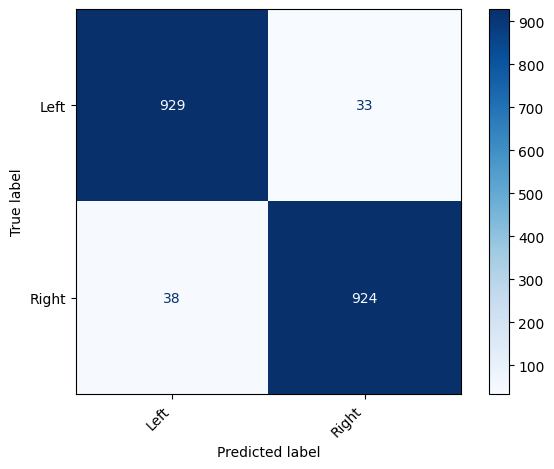

In [42]:
# pick the split you want to inspect (e.g. "validation" or "test")
eval_split = ds_tokenized["validation"]  # change if your split is named differently

pred_output = trainer.predict(eval_split)
y_true = pred_output.label_ids
y_pred = pred_output.predictions.argmax(axis=-1)

id2label = {0: "Left", 1: "Right"}
label_ids = [0, 1]
label_list = ["Left", "Right"]
label_ids = sorted(id2label)       
label_list = [id2label[i] for i in label_ids]

cm = confusion_matrix(y_true, y_pred, labels=label_ids)
disp = ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(values_format="d", cmap="Blues")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()